# Nearest neighbor with KDTree


In [77]:
from scipy.spatial import KDTree, distance
import numpy as np
from pprint import pp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [78]:
# Example
points_ref = np.array([(1, 1), (3, 3), (4, 4), (5, 4), (6, 6)])
refTree = KDTree(points_ref)
idx = refTree.query_ball_point((4, 4), 2)
pp(idx)
pp(points_ref[idx])

[1, 2, 3]
array([[3, 3],
       [4, 4],
       [5, 4]])


In [79]:
# Constructing centroids of zones
ncol = 2
nZones = 6
nrows = nZones

# Make sure I have unique index
idxStart = random.randint(100, 200)
cols = [f"W{i+1}" for i in range(ncol)]
idx = [f"c{i+idxStart}" for i in range(nrows)]
X = pd.DataFrame(np.random.random(size=(nrows, ncol)), columns=cols, index=idx)
y = [i for i in range(nrows)]
y = pd.Series(y, index=idx, name="Cy")
zc = pd.concat([y, X], axis=1)
zc = zc.sample(frac=1)
display(zc)

,Cy,W1,W2
c137,4,0.570686,0.392485
c135,2,0.813671,0.297421
c134,1,0.288783,0.296378
c138,5,0.184421,0.423396
c136,3,0.081964,0.757009
c133,0,0.547092,0.919973


In [80]:
# Constructing unsupervised fingerprints
nrows = 200
idxStart = random.randint(100, 200)
idx = [f"u{i+idxStart}" for i in range(nrows)]
uFp = pd.DataFrame(np.random.random(size=(nrows, ncol)), columns=cols, index=idx)
display(uFp)

,W1,W2
u101,0.430601,0.047275
u102,0.554933,0.224875
u103,0.714986,0.189341
u104,0.806213,0.514009
u105,0.583759,0.782489
...,...,...
u296,0.827909,0.842042
u297,0.349641,0.934232
u298,0.049255,0.529466
u299,0.134276,0.321210


<Axes: xlabel='W1', ylabel='W2'>

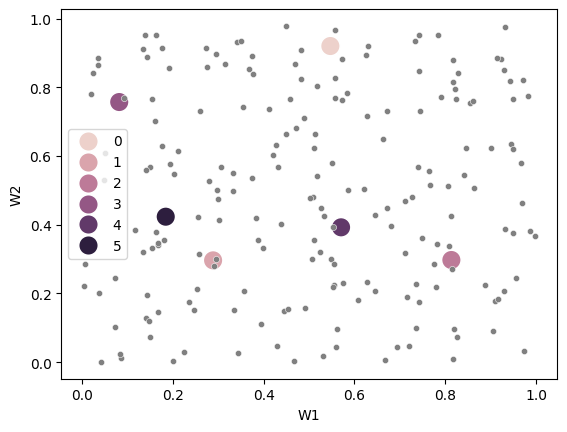

In [81]:
fig, ax = plt.subplots()
sns.scatterplot(zc, x="W1", y="W2", hue="Cy", ax=ax, s=200)
sns.scatterplot(uFp, x="W1", y="W2", ax=ax, color="gray", s=20)

In [82]:
# Find nearest neighbors
refPts = zc[cols]
refLabels = zc["Cy"]
queryPts = zc[cols]
removeSelf = True
k = 6

# ---------------------------------
refTree = KDTree(refPts)
distArr, idxArr = refTree.query(queryPts, k=k)
if removeSelf:
    distArr = distArr[:, 1:]
    idxArr = idxArr[:, 1:]
    k = k - 1
pp(idxArr)
pp(distArr)


def rowFn(row, refPts, refLabels):
    k = int(row.shape[0] / 2)
    srIdx = row.iloc[:k].reset_index(drop=True).astype(int)
    nnCy = srIdx.apply(
        lambda idx: refLabels.iloc[idx] if idx < refLabels.shape[0] else None
    )
    nnCyIdx = srIdx.apply(
        lambda idx: refPts.index.values[idx] if idx < refPts.shape[0] else None
    )

    nnCyDist = row.iloc[k:].reset_index(drop=True)
    nnCyDist.replace([np.inf, -np.inf], None, inplace=True)
    dft = pd.DataFrame({"nnCy": nnCy, "nnCyDist": nnCyDist, "nnCyIdx": nnCyIdx})
    dft = dft.dropna()
    res = pd.Series(
        [
            dft["nnCy"].values.tolist(),
            dft["nnCyDist"].values.tolist(),
            dft["nnCyIdx"].values.tolist(),
            dft.shape[0],
        ],
        index=["nnCy", "nnCyDist", "nnCyIdx", "nnCyK"],
    )
    return res


dft = pd.DataFrame(np.concatenate([idxArr, distArr], axis=1), index=refPts.index)
zcSelfNn = dft.apply(lambda row: rowFn(row, refPts, refLabels), axis=1)
display(zcSelfNn)

array([[1, 2, 3, 5, 4],
       [0, 2, 3, 5, 4],
       [3, 0, 4, 1, 5],
       [2, 4, 0, 5, 1],
       [3, 5, 2, 0, 1],
       [4, 0, 3, 2, 1]], dtype=int64)
array([[0.26091887, 0.29783555, 0.38749976, 0.52801522, 0.60969449],
       [0.26091887, 0.52488886, 0.64173566, 0.67722558, 0.86406951],
       [0.16439304, 0.29783555, 0.5049313 , 0.52488886, 0.67497756],
       [0.16439304, 0.34899172, 0.38749976, 0.61491362, 0.64173566],
       [0.34899172, 0.49285054, 0.5049313 , 0.60969449, 0.86406951],
       [0.49285054, 0.52801522, 0.61491362, 0.67497756, 0.67722558]])


,nnCy,nnCyDist,nnCyIdx,nnCyK
c137,"[2, 1, 5, 0, 3]","[0.2609188660439538, 0.2978355527433826, 0.387...","[c135, c134, c138, c133, c136]",5
c135,"[4, 1, 5, 0, 3]","[0.2609188660439538, 0.5248888555215562, 0.641...","[c137, c134, c138, c133, c136]",5
c134,"[5, 4, 3, 2, 0]","[0.16439303656168278, 0.2978355527433826, 0.50...","[c138, c137, c136, c135, c133]",5
c138,"[1, 3, 4, 0, 2]","[0.16439303656168278, 0.3489917189833242, 0.38...","[c134, c136, c137, c133, c135]",5
c136,"[5, 0, 1, 4, 2]","[0.3489917189833242, 0.4928505364310717, 0.504...","[c138, c133, c134, c137, c135]",5
c133,"[3, 4, 5, 1, 2]","[0.4928505364310717, 0.5280152230433992, 0.614...","[c136, c137, c138, c134, c135]",5


In [83]:
refPts = uFp[cols]
queryPts = zc[cols]
queryRadius = zcSelfNn["nnCyDist"].apply(lambda d: d[0])
queryRadius = queryRadius * 0.5  # Half distance to nearnest neighbor


def getNN(row, refTree, refPts):
    radius = row["radius"]
    srIdx = [idx for idx in row.index if idx not in ["radius"]]
    pt = row[srIdx]
    nnIdx = refTree.query_ball_point(pt, radius)

    refPtsSelected = refPts.iloc[nnIdx, :]
    _dists = distance.cdist([pt], refPtsSelected)
    dists = pd.Series(_dists[0], index=refPtsSelected.index, name="nnAugDist")
    dfRes = pd.concat([refPtsSelected, dists], axis=1)
    dfRes = dfRes.sort_values(by="nnAugDist")
    res = pd.Series(
        [dfRes.index.values.tolist(), dfRes["nnAugDist"].values.tolist(), dfRes.shape[0]],
        index=["nnAugIdx", "nnAugDist", "nnAugK"],
    )
    return res


refTree = KDTree(refPts)
queryRadius.name = "radius"
dft = pd.concat([queryPts, queryRadius], axis=1)
zcAug = dft.apply(lambda row: getNN(row, refTree, refPts), axis=1)
display(zcAug)

,nnAugIdx,nnAugDist,nnAugK
c137,"[u120, u125, u189, u145, u206, u141, u151, u28...","[0.018450092424654677, 0.051055618071312425, 0...",15
c135,"[u174, u149, u245, u239, u163, u241, u226, u15...","[0.02645866239070767, 0.040945439045987124, 0....",10
c134,"[u212, u251, u153]","[0.008535331244815755, 0.016777429940870777, 0...",3
c138,"[u191, u249, u242, u232, u165]","[0.04943106255663705, 0.06843058296791264, 0.0...",5
c136,"[u246, u166, u118, u220, u106, u154, u134, u24...","[0.016820108740315986, 0.0659801123713422, 0.0...",14
c133,"[u275, u214, u131, u187, u234, u122, u136, u13...","[0.04573470555833459, 0.04898807021122808, 0.0...",28


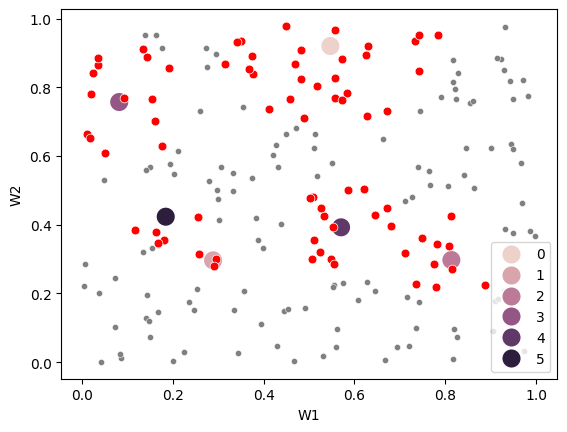

In [84]:
fig, ax = plt.subplots()
sns.scatterplot(zc, x="W1", y="W2", hue="Cy", ax=ax, s=200)
sns.scatterplot(uFp, x="W1", y="W2", ax=ax, color="gray", s=20)

for idx in zc.index:
    idxAug = zcAug.loc[idx, "nnAugIdx"]
    augPts = uFp.loc[idxAug, :]
    sns.scatterplot(augPts, x="W1", y="W2", ax=ax, color="red", s=40)